In [ ]:
# import relevant libraries

import pandas as pd
import numpy as np
import cv2
import os
import sklearn
from sklearn.metrics import accuracy_score, f1_score, cohen_kappa_score, roc_curve, auc, precision_recall_curve, confusion_matrix, classification_report
from sklearn.metrics import mean_squared_error, roc_auc_score, average_precision_score, mean_squared_error
import random
from google.colab import drive
import torch
import torchvision
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from tqdm import tqdm
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import torchvision.transforms.functional as TF
import math

##DataSet

In [ ]:
# load the datasets
!tar -xvf'.../test_set.tar'
!tar -xvf '.../train_and_val_set.tar'

In [ ]:
# a function to create a dataset such that each image is saved with its corresponding labels 

class ImageDataset(Dataset):
    def __init__(self, img_folder, label_folder, transform=None):
        self.img_folder = img_folder
        self.label_folder = label_folder
        self.transform = transform
        self.img_files = os.listdir(img_folder)

    def __len__(self):
        return len(self.img_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_folder, self.img_files[idx])
        img = Image.open(img_path).convert('RGB')

        if self.transform:
            img = self.transform(img)

        # Load annotations
        label_valence_file = os.path.join(self.label_folder, f"{os.path.splitext(self.img_files[idx])[0]}_val.npy")
        label_arousal_file = os.path.join(self.label_folder, f"{os.path.splitext(self.img_files[idx])[0]}_aro.npy")
        label_expr_file = os.path.join(self.label_folder, f"{os.path.splitext(self.img_files[idx])[0]}_exp.npy")

        label_valence = np.load(label_valence_file)
        label_arousal = np.load(label_arousal_file)
        label_expr = np.load(label_expr_file)

        label = {'valence': label_valence, 'arousal': label_arousal, 'expression': label_expr}

        return img, label

In [ ]:
# a simple transform that will be applied to every element in each dataset

transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) 
])

In [ ]:
# Create dataset
dataset = ImageDataset(img_folder='/content/train_set/images', label_folder='/content/train_set/annotations', transform=transform)

In [ ]:
# split the dataset into train and testing
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

In [ ]:
# redefine the collate_fn function for the dataloader as per the dataset
def collate_fn(batch):
    data = [item[0] for item in batch]
    target = [item[1] for item in batch]
    data = torch.stack(data, 0)
    return [data, target]

In [ ]:
# Load the datasets to the dataloader
# the batch size of test loader is 1 for time and computation efficiency
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False, collate_fn=collate_fn, pin_memory=True)

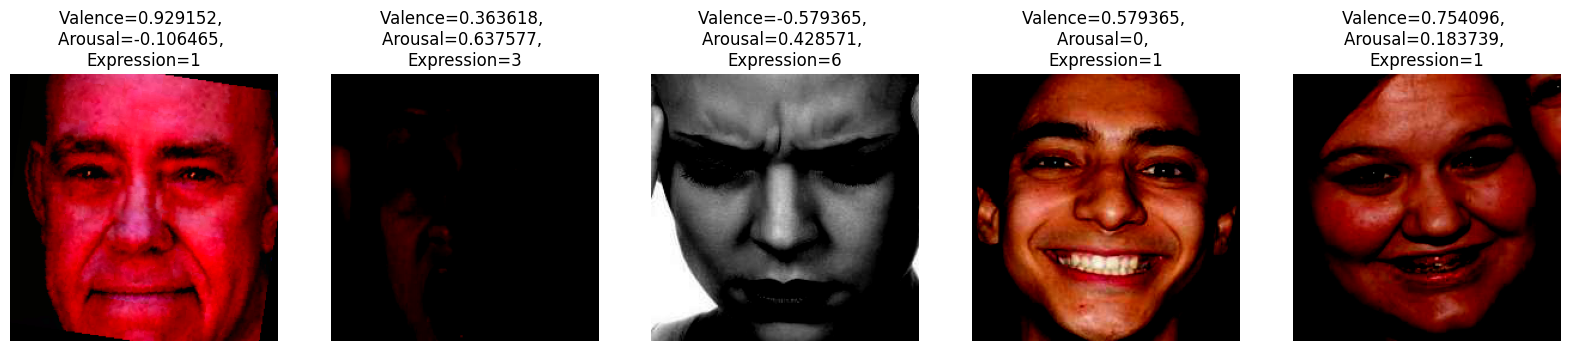

In [ ]:
# Visualise some of the images in the dataset with its labels

fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(20, 10))
indices = np.random.choice(range(len(dataset)), size=5, replace=False)
for i, ax in zip(indices, axes):
    img, labels = dataset[i]
    ax.imshow(img.permute(1, 2, 0))
    ax.set_title(f"Valence={labels['valence']}, \nArousal={labels['arousal']}, \nExpression={labels['expression']}")
    ax.axis('off')
plt.show()


##Model

In [ ]:
# model choosen is resnet18, with pretained = False

resnet18 = torchvision.models.resnet18(pretrained= False)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [ ]:
resnet18

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
# Freeze the parameters of the last fully connected layer
for param in resnet18.fc.parameters():
    param.requires_grad = True

In [ ]:
# A class is defined to create 3 FC layers connected parallely 
# This is because our task is to give 2 regression outputs and 1 classification output

class CustomClassifier(nn.Module):
    def __init__(self, in_features):
        super().__init__()
        self.fc1 = nn.Linear(in_features, 1)
        self.fc2 = nn.Linear(in_features, 1)
        self.fc3 = nn.Linear(in_features, 8)

    def forward(self, x):
        out1 = self.fc1(x)
        out2 = self.fc2(x)
        out3 = self.fc3(x)
        return out1, out2, out3

In [ ]:
# The no of input features in the FC layer of Resnet
num_ftrs = resnet18.fc.in_features

In [ ]:
# Replace the FC layer of the model with the Custom Classifier
resnet18.fc = CustomClassifier(num_ftrs)

In [ ]:
print('No.of parameters: ', sum(p.numel() for p in resnet18.parameters()))

No.of parameters:  11181642


In [ ]:
# Save the model on the device

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet18.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

##Testing

In [ ]:
# Download the best validation performance model from the models shared

!gdown https://drive.google.com/file/d/1J5XDuVNUF45j64hXeKe1i4qaxb_Uhav9/view?usp=share_link --fuzzy

Downloading...
From: https://drive.google.com/uc?id=1FfmZwn01Ozt7XZ50KyqwLW8gqlUrE-m8
To: /content/best_val_checkpoint_resnet18.pth
100% 134M/134M [00:01<00:00, 132MB/s]


In [ ]:
# Load the model

best_val_model_path = '/content/best_val_checkpoint_resnet18.pth'
best_val_resnet18 = torch.load(best_val_model_path, map_location=torch.device(device))

In [ ]:
# Load the state dictionary

resnet18.load_state_dict(best_val_resnet18['model'])

<All keys matched successfully>

In [ ]:
# Define a function to run the test loader on the model

def run_test_imgs(model, dataloader):
    exp_labs = []
    exp_preds = []
    val_labs = []
    val_preds = []
    aro_labs = []
    aro_preds = []

    with torch.no_grad():
      for images, labels in tqdm(dataloader):

          valence_labels = []
          arousal_labels = []
          expr_labels = []
          for i in range(len(labels)):
            valence_labels.append([float(labels[i]['valence'])])
            arousal_labels.append([float(labels[i]['arousal'])])
            expr_labels.append(int(labels[i]['expression']))

          valence_labels = torch.tensor(valence_labels)
          arousal_labels = torch.tensor(arousal_labels)
          expr_labels = torch.tensor(expr_labels)

          valence_labels = (valence_labels).to(device)
          arousal_labels = (arousal_labels).to(device)
          expr_labels = (expr_labels).to(device)
          images = (images).to(device)
          
          # Run the model
          outputs = model(images)

          # Separate the outputs into regression and categorical predictions
          valence_preds, arousal_preds, expr_preds = outputs[0], outputs[1], outputs[2]

          expr_preds_2 = []
          for i in expr_preds:
            expr_preds_2.append(torch.argmax(i))
          expr_preds_2 = [t.item() for t in expr_preds_2]
          expr_labels = expr_labels.tolist()

          exp_labs.extend(expr_labels)
          exp_preds.extend(expr_preds_2)
          val_labs.extend(valence_labels)
          val_preds.extend(valence_preds)
          aro_labs.extend(arousal_labels)
          aro_preds.extend(arousal_preds)

    return exp_labs, exp_preds, val_labs, val_preds, aro_labs, aro_preds

In [ ]:
# Find the predictions 
exp_labs_test, exp_preds_test, val_labs_test, val_preds_test, aro_labs_test, aro_preds_test = run_test_imgs(resnet18, test_dataloader)

100%|██████████| 57531/57531 [18:12<00:00, 52.68it/s]


####Evaluation

In [1]:
# Some functions definition used to calculate some metrics
# All of these functions are available in another notebook and can be imported from there too

# A function to find the Krippendorffs Alpha
def krippendorff_alpha(preds, labels):
    # Calculate observed agreement
    obs_agree = np.sum(preds == labels) / len(preds)

    # Calculate expected agreement
    unique_labels = np.unique(labels)
    freq = np.zeros((len(unique_labels), len(preds)))
    for i, label in enumerate(unique_labels):
        freq[i] = preds == label
    exp_agree = np.sum(np.sum(freq, axis=0) * np.sum(freq, axis=0)) / (len(preds) * len(unique_labels))

    # Calculate alpha
    alpha = 1 - (1 - obs_agree) / (1 - exp_agree)
    
    return alpha

def auc_fn(predictions, labels):
    # convert preds and labs to numpy arrays
    preds = np.array(predictions)
    labs = np.array(labels)

    # calculate the one-hot encoding of the labels
    n_classes = len(np.unique(labs))
    one_hot_labs = np.zeros((len(labs), n_classes))
    one_hot_labs[np.arange(len(labs)), labs] = 1

    # calculate the ROC curve and AUC for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(one_hot_labs[:, i], preds == i)
        roc_auc[i] = auc(fpr[i], tpr[i])

    # calculate the average AUC across all classes
    avg_auc = np.mean(list(roc_auc.values()))

    return avg_auc

def auc_pr_fn(preds, labs):
    n_classes = len(set(labs))
    auc_pr = []

    for i in range(n_classes):
        y_true = [1 if x == i else 0 for x in labs]
        y_score = [1 if x == i else 0 for x in preds]
        precision, recall, _ = precision_recall_curve(y_true, y_score)
        area = auc(recall, precision)
        auc_pr.append(area)
    
    auc_pr_mean = sum(auc_pr)/len(auc_pr)
    return auc_pr, auc_pr_mean

def sagr(y_true, y_pred):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    y_true_sign = np.sign(y_true)
    y_pred_sign = np.sign(y_pred)
    sagr_value = np.mean(y_true_sign == y_pred_sign)
    return sagr_value

def concordance_correlation_coefficient(x, y):
    # Compute means and standard deviations of x and y
    x_mean, y_mean = np.mean(x), np.mean(y)
    x_std, y_std = np.std(x), np.std(y)
    
    # Compute covariance and correlation coefficient between x and y
    covariance = np.cov(x, y)[0][1]
    correlation_coefficient = covariance / (x_std * y_std)
    
    # Compute the mean square error between x and y
    mse_x = np.mean(np.square(x - x_mean))
    mse_y = np.mean(np.square(y - y_mean))
    mean_square_error = (mse_x + mse_y) / 2
    
    # Compute the concordance correlation coefficient
    concordance_correlation_coefficient = 2 * correlation_coefficient * np.sqrt(mse_x) * np.sqrt(mse_y) / \
        (np.square(x_std) + np.square(y_std) + np.square(x_mean - y_mean))
    
    return concordance_correlation_coefficient

In [ ]:
# Categorical Classification Performance

acc = accuracy_score(exp_preds_test, exp_labs_test)
f1score = f1_score(exp_preds_test, exp_labs_test,  average='weighted')
kappa = cohen_kappa_score(exp_preds_test, exp_labs_test)
alpha = krippendorff_alpha(exp_preds_test, exp_labs_test)
AUC = auc_fn(exp_preds_test, exp_labs_test)
AUC_PR, AUC_PR_mean = auc_pr_fn(exp_preds_test, exp_labs_test)

In [ ]:
print('Expression Testing Evaluation')
print(f'Accuracy: {acc*100:2f}% \nF1-Score: {f1score:2f} \nCohens Kappa: {kappa:2f} \nKrippendorffs Alpha: {alpha:2f} \nArea Under Curve: {AUC:2f} \nArea under Precision-Recall Curve Mean:  {AUC_PR_mean:2f}')
print('AUC_PR: ',AUC_PR)

Expression Testing Evaluation
Accuracy: 76.762093% 
F1-Score: 0.780255 
Cohens Kappa: 0.656322 
Krippendorffs Alpha: -0.142857 
Area Under Curve: 0.719457 
Area under Precision-Recall Curve Mean:  0.561028
AUC_PR:  [0.7517374729987578, 0.9268559461198285, 0.6192236069563699, 0.5281761986050476, 0.49214002053199013, 0.3985910856755488, 0.6379356001841503, 0.13356494759347134]


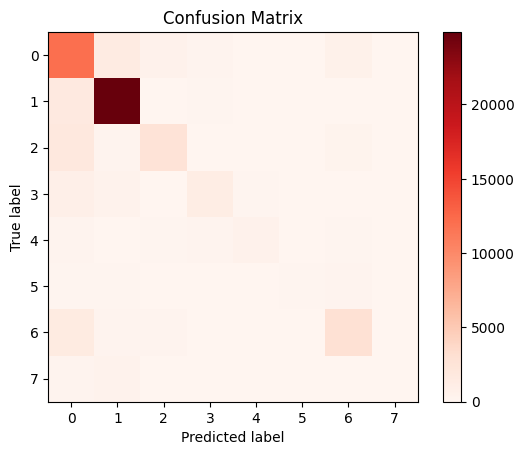

In [ ]:
conf_matrix = confusion_matrix(exp_labs_test, exp_preds_test)

# Plot confusion matrix as image with color map
plt.imshow(conf_matrix, cmap='Reds')

# Set plot labels
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.xticks(np.arange(len(np.unique(exp_labs_test))), np.unique(exp_labs_test))
plt.yticks(np.arange(len(np.unique(exp_preds_test))), np.unique(exp_preds_test))
plt.colorbar()

# Show plot
plt.show()

In [ ]:
# Classification Report
print(classification_report(exp_labs_test, exp_preds_test))

              precision    recall  f1-score   support

           0       0.65      0.81      0.72     14837
           1       0.89      0.92      0.91     26935
           2       0.69      0.50      0.58      5083
           3       0.61      0.42      0.50      2817
           4       0.60      0.37      0.46      1317
           5       0.56      0.22      0.32       762
           6       0.66      0.58      0.62      5018
           7       0.25      0.00      0.01       762

    accuracy                           0.77     57531
   macro avg       0.61      0.48      0.51     57531
weighted avg       0.76      0.77      0.75     57531



In [ ]:
# transform the regression outputs
val_labs_test = (torch.cat(val_labs_test)).cpu()
val_preds_test = (torch.cat(val_preds_test)).cpu().detach()
aro_labs_test = (torch.cat(aro_labs_test)).cpu()
aro_preds_test = (torch.cat(aro_preds_test)).cpu().detach()

In [ ]:
# Regression Performance

val_rmse = np.sqrt(mean_squared_error(val_labs_test, val_preds_test))
aro_rmse = np.sqrt(mean_squared_error(aro_labs_test, aro_preds_test))
val_corr = np.corrcoef(val_labs_test, val_preds_test)[0, 1]
aro_corr = np.corrcoef(aro_labs_test, aro_preds_test)[0, 1]
val_sagr = sagr(val_labs_test, val_preds_test)
aro_sagr = sagr(aro_labs_test, aro_preds_test)
val_ccc = concordance_correlation_coefficient(val_labs_test.tolist(), val_preds_test.tolist())
aro_ccc = concordance_correlation_coefficient(aro_labs_test.tolist(), aro_preds_test.tolist())

In [ ]:
print('Valence Testing Evaluation')
print(f'Root Mean Square Error: {val_rmse:2f} \nCorrelation: {val_corr:2f} \nSign Agreement Metric: {val_sagr:2f} \nConcordance Correlation Coefficient: {val_ccc:2f}')

Valence Testing Evaluation
Root Mean Square Error: 0.285359 
Correlation: 0.834194 
Sign Agreement Metric: 0.831100 
Concordance Correlation Coefficient: 0.819518


In [ ]:
print('Arousal Testing Evaluation')
print(f'Root Mean Square Error: {aro_rmse:2f} \nCorrelation: {aro_corr:2f} \nSign Agreement Metric: {aro_sagr:2f} \nConcordance Correlation Coefficient: {aro_ccc:2f}')

Arousal Testing Evaluation
Root Mean Square Error: 0.236502 
Correlation: 0.624095 
Sign Agreement Metric: 0.702873 
Concordance Correlation Coefficient: 0.557798


In [ ]:
# To find 2 correctly and incorrectly classified images
# and store their corresponding labels and predictions
correct_count = 0
incorrect_count = 0
imgs_c = []
exp_labs_c = []
exp_preds_c = []
val_labs_c = []
val_preds_c = []
aro_labs_c = []
aro_preds_c = []
imgs_i = []
exp_labs_i = []
exp_preds_i = []
val_labs_i = []
val_preds_i = []
aro_labs_i = []
aro_preds_i = []

with torch.no_grad():
  for images, labels in test_dataloader:
    valence_labels = []
    arousal_labels = []
    expr_labels = []
    for i in range(len(labels)):
      valence_labels.append([float(labels[i]['valence'])])
      arousal_labels.append([float(labels[i]['arousal'])])
      expr_labels.append(int(labels[i]['expression']))

    valence_labels = torch.tensor(valence_labels)
    arousal_labels = torch.tensor(arousal_labels)
    expr_labels = torch.tensor(expr_labels)

    valence_labels = (valence_labels).to(device)
    arousal_labels = (arousal_labels).to(device)
    expr_labels = (expr_labels).to(device)
    images = (images).to(device)
    
    # Run the model
    outputs = resnet18(images)

    # Separate the outputs into regression and categorical predictions
    valence_preds, arousal_preds, expr_preds = outputs[0], outputs[1], outputs[2]

    expr_preds_2 = []
    for i in expr_preds:
      expr_preds_2.append(torch.argmax(i))
    expr_preds_2 = [t.item() for t in expr_preds_2]
    expr_labels = expr_labels.tolist()

    if expr_preds_2 == expr_labels and correct_count < 2:
      correct_count += 1
      imgs_c.extend(images)
      exp_labs_c.extend(expr_labels)
      exp_preds_c.extend(expr_preds_2)
      val_labs_c.extend(valence_labels)
      val_preds_c.extend(valence_preds)
      aro_labs_c.extend(arousal_labels)
      aro_preds_c.extend(arousal_preds)
    elif expr_preds_2 != expr_labels and incorrect_count < 2:
      incorrect_count += 1
      imgs_i.extend(images)
      exp_labs_i.extend(expr_labels)
      exp_preds_i.extend(expr_preds_2)
      val_labs_i.extend(valence_labels)
      val_preds_i.extend(valence_preds)
      aro_labs_i.extend(arousal_labels)
      aro_preds_i.extend(arousal_preds)
    if correct_count >= 2 and incorrect_count >= 2:
      break

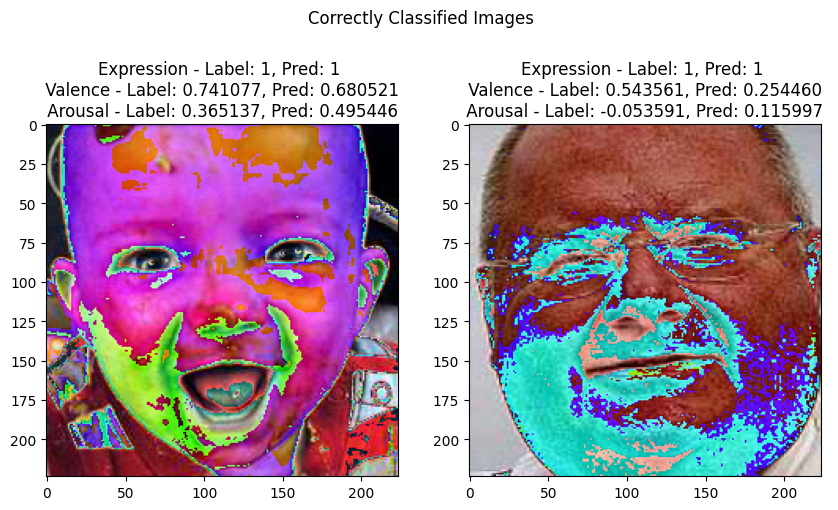

In [ ]:
# Correctly Classified Images 

fig, axs = plt.subplots(1, 2, figsize=(10,6))
fig.suptitle('Correctly Classified Images')

for i, (img, exp_lab, val_lab, aro_lab, exp_pred, val_pred, aro_pred) in enumerate(zip(imgs_c, exp_labs_c, val_labs_c, aro_labs_c, exp_preds_c, val_preds_c, aro_preds_c)):
    col = i % 2
    img = TF.to_pil_image(img)
    axs[col].imshow(img) 
    axs[col].set_title(f"Expression - Label: {exp_lab}, Pred: {exp_pred} \n Valence - Label: {val_lab.item():2f}, Pred: {val_pred.item():2f} \n Arousal - Label: {aro_lab.item():2f}, Pred: {aro_pred.item():2f} ")
plt.show()

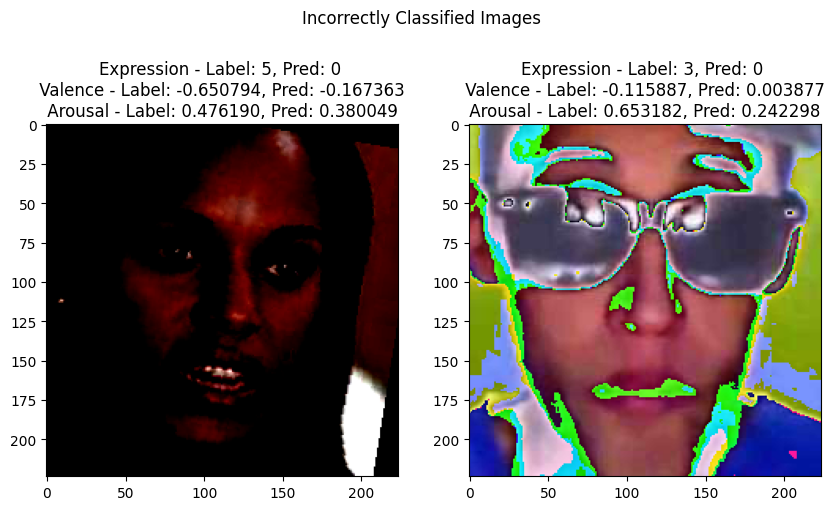

In [ ]:
#Incorrectly Classified Images 

fig, axs = plt.subplots(1, 2, figsize=(10,6))
fig.suptitle('Incorrectly Classified Images')

for i, (img, exp_lab, val_lab, aro_lab, exp_pred, val_pred, aro_pred) in enumerate(zip(imgs_i, exp_labs_i, val_labs_i, aro_labs_i, exp_preds_i, val_preds_i, aro_preds_i)):
    col = i % 2
    img = TF.to_pil_image(img)
    axs[col].imshow(img) 
    axs[col].set_title(f"Expression - Label: {exp_lab}, Pred: {exp_pred} \n Valence - Label: {val_lab.item():2f}, Pred: {val_pred.item():2f} \n Arousal - Label: {aro_lab.item():2f}, Pred: {aro_pred.item():2f} ")
plt.show()